In [1]:
using Lattice2D, Random

Lx = 10
Ly = 10
model = Ising
lat = build_lattice(Kagome, Lx, Ly)
rng = Xoshiro()
grids = rand([-1, 1], lat.N)
kbT = 2.5
alg = localupdate
observers = [EnergyObserver(), MagnetizationObserver(), ConfigurationObserver{Int}()]
nsteps = 1000
run!(rng, grids, lat, kbT, model, alg, observers, nsteps)


[ Info: Precompiling Lattice2D [e8031020-b7ff-4f1d-bee4-f79aea4cf140] (cache misses: include_dependency fsize change (2), wrong source (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing Lattice2D [e8031020-b7ff-4f1d-bee4-f79aea4cf140].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


[ Info: Saved animation to /home/souta/work/Lattice2DIsing.jl/notebook/Honeycomb_L=16.gif
[ Info: Saved animation to /home/souta/work/Lattice2DIsing.jl/notebook/Kagome_L=16.gif


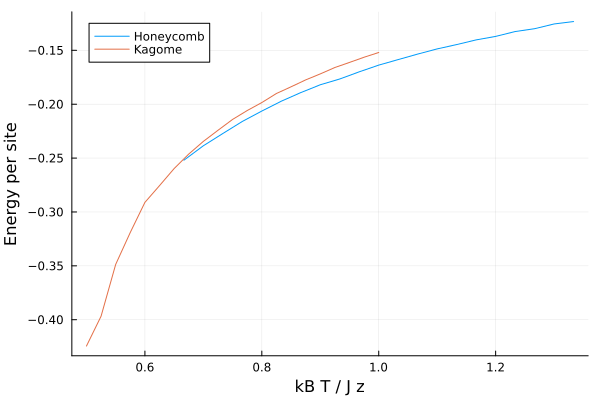

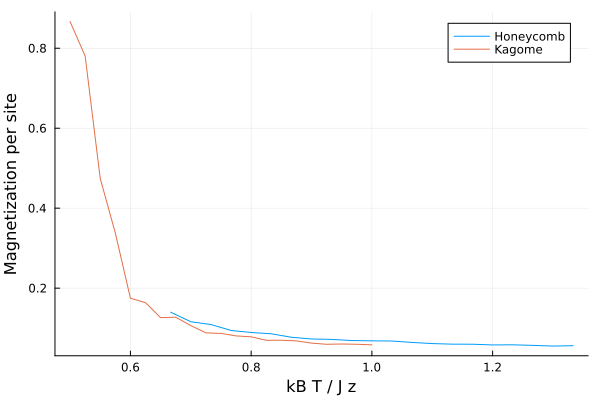

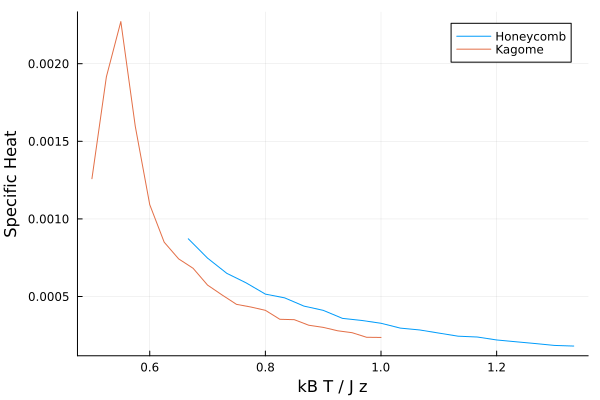

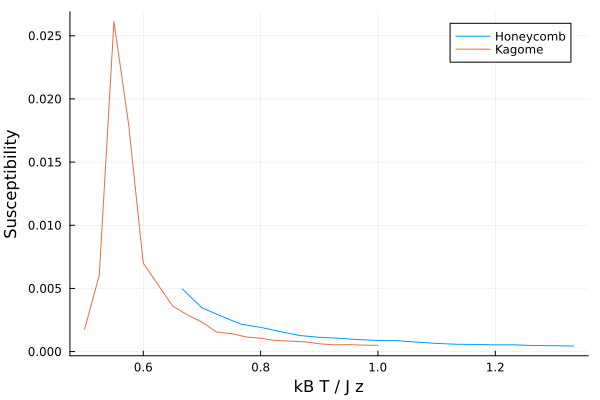

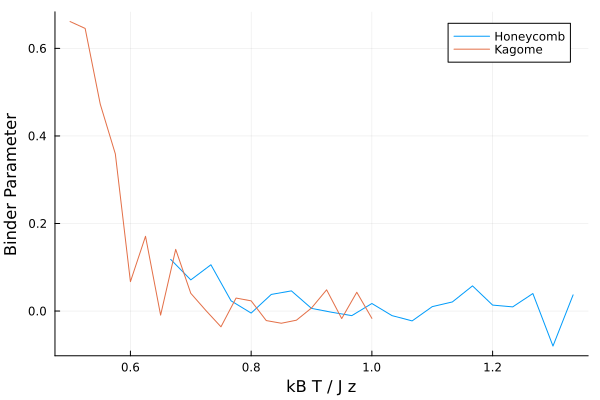

In [3]:
using Lattice2D
using Random, Statistics, Plots
using LinearAlgebra

import Lattice2D: AbstractModel, AbstractObserver, run!, observe!
gr()
# visualization methods
const p_init = plot(;
    aspect_ratio=:equal, grid=false, axis=false, ticks=false, legend=:bottomright
)
function find_marker_size(lat::Lattice; ms_scale=80.0)
    min_dist = 0.0
    if isempty(lat.bonds)
        min_dist = 1.0
    else
        min_dist = minimum([
            norm(lat.positions[b.src] - lat.positions[b.dst]) for b in lat.bonds
        ])
    end
    xs = [p[1] for p in lat.positions]
    ys = [p[2] for p in lat.positions]
    area = [(maximum(xs) - minimum(xs)), (maximum(ys) - minimum(ys))]
    scaling = min_dist / norm(area)

    marker_size = ms_scale * scaling
    return marker_size
end
function visualize_bonds(p, lat::Lattice)
    threhold = 1.5 * maximum(norm.(lat.unit_cell.basis))
    seg_x, seg_y = Float64[], Float64[]
    for bond in lat.bonds
        src_pos = lat.positions[bond.src]
        dst_pos = lat.positions[bond.dst]
        if norm(dst_pos - src_pos) < threhold
            push!(seg_x, src_pos[1], dst_pos[1], NaN)
            push!(seg_y, src_pos[2], dst_pos[2], NaN)
        end
    end
    return plot!(p, seg_x, seg_y; color=:black, lw=1.0, label="")
end
function plot_spins(
    p, lat::Lattice, spins::AbstractVector; ms_scale=find_marker_size(lat), title_str=""
)
    marker_size = ms_scale * 3.0
    xs = [p[1] for p in lat.positions]
    ys = [p[2] for p in lat.positions]

    colors = [spins[i] > 0 ? :red : :blue for i in 1:(lat.N)]
    scatter!(
        p, xs, ys; ms=marker_size, mc=colors, markerstrokewidth=0, label="", title=title_str
    )
    return p
end
function visualize_realtime!(p; sleep_time=0.001)
    IJulia.clear_output(true)
    display(p)
    sleep(sleep_time)
    return nothing
end
function make_animation(p_list; fps=5, filename="ising_simulation.gif")
    anim = @animate for p in p_list
        plot(p)
    end
    return gif(anim, filename; fps=fps)
end
@kwdef mutable struct PlotFrameObserver{T} <: Lattice2D.AbstractObserver # <--- Tを明記
    interval::Int = 100
    p_init::Plots.Plot = plot()
    p_list::Vector{Plots.Plot} = Plots.Plot[]
    lat::Lattice
    steps::Vector{Int} = Int[] # 時刻も追加
end
function observe!(
    obs::PlotFrameObserver{T},
    grids::AbstractVector{T},
    lat::Lattice,
    kbT::Float64,
    model::AbstractModel{T},
    step::Int,
) where {T}
    p = deepcopy(obs.p_init)
    p = visualize_bonds(p, lat)
    p = plot_spins(
        p, lat, grids; title_str=string(lat.topology, " kbT=", kbT, " Step=", step)
    )
    push!(obs.p_list, p)
    return nothing
end


AVAILABLE_LATTICES = [Honeycomb, Kagome]

p_eng = plot(xlabel="kB T / J z", ylabel="Energy per site")
p_mag = plot(xlabel="kB T / J z", ylabel="Magnetization per site")
p_spacific_heat = plot(xlabel="kB T / J z", ylabel="Specific Heat")
p_susceptibility = plot(xlabel="kB T / J z", ylabel="Susceptibility")
p_binder = plot(xlabel="kB T / J z", ylabel="Binder Parameter")

rng = Xoshiro(1234)
for Lattice in AVAILABLE_LATTICES
    Lx, Ly = 16, 16
    lat = build_lattice(Lattice, Lx, Ly)
    z = mean(length.(lat.nearest_neighbors))

    grids = rand(rng, [-1, 1], lat.N)
    kbT_list = collect(2.0:0.1:4.0)

    eng = zeros(length(kbT_list))
    mag = zeros(length(kbT_list))
    spacific_heat = zeros(length(kbT_list))
    susceptibility = zeros(length(kbT_list))
    binder = zeros(length(kbT_list))
    p_frames_all = Plots.Plot[]

    model = IsingModel(J=1.0, h=0.0)
    alg = LocalUpdate()

    n_thermal = 5000
    n_steps = 5000

    for (i, kbT) in enumerate(kbT_list)
        obs_eng = EnergyObserver(interval=1)
        obs_mag = MagnetizationObserver(interval=1)
        obs_frame = PlotFrameObserver{Int}(interval=100, lat=lat, p_init=p_init)

        run!(rng, grids, lat, kbT, model, alg, Lattice2D.AbstractObserver[], n_thermal)

        observers = [obs_eng, obs_mag, obs_frame]
        run!(rng, grids, lat, kbT, model, alg, observers, n_steps)
        energies = obs_eng.history
        magnetizations = obs_mag.history

        eng[i] = mean(energies) / z
        mag[i] = mean(abs.(magnetizations))

        spacific_heat[i] = var(energies) / (kbT^2)
        susceptibility[i] = var(magnetizations) / kbT

        mean_M2 = mean(magnetizations .^ 2)
        mean_M4 = mean(magnetizations .^ 4)
        binder[i] = 1.0 - (mean_M4 / (3 * mean_M2^2))

        append!(p_frames_all, obs_frame.p_list)
    end

    make_animation(p_frames_all; fps=10, filename=string(Lattice, "_L=", Lx, ".gif"))

    kbT_list_norm = kbT_list ./ z
    plot!(p_eng, kbT_list_norm, eng; label=string(Lattice))
    plot!(p_mag, kbT_list_norm, mag; label=string(Lattice))
    plot!(p_spacific_heat, kbT_list_norm, spacific_heat; label=string(Lattice))
    plot!(p_susceptibility, kbT_list_norm, susceptibility; label=string(Lattice))
    plot!(p_binder, kbT_list_norm, binder; label=string(Lattice))
end

display(p_eng)
display(p_mag)
display(p_spacific_heat)
display(p_susceptibility)
display(p_binder)
